In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [7]:
data_dir = "/Users/vedparanjape/Downloads/Tensorflow-Bootcamp-master/04-Recurrent-Neural-Networks/word2vec_data/words"

In [8]:
def fetch_words_data(words_data = data_dir):
    zip_path = os.path.join(words_data,"words.zip")
    
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    return data.decode("ascii").split()


In [16]:
words = fetch_words_data()
from collections import Counter

anarchism


In [17]:
#get 50000 most common words
def create_counts(vocab_size = 50000):
    vocab = [] + Counter(words).most_common(vocab_size)
    
    vocab = np.array([word for word,_ in vocab])
    
    dictionary = {word:code for code,word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word,0) for word in words])
    
    return data, vocab

In [19]:
data,vocabulary = create_counts()

In [21]:
print(data.shape)

(17005207,)


In [23]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

In [26]:
batch_size = 128
embedding_size = 150
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100

In [27]:
valid_examples = np.random.choice(valid_window,valid_size,replace=False)


In [28]:
num_samples = 64
learning_rate = 0.01
vocabulary_size = 50000
tf.reset_default_graph()


In [30]:
train_inputs = tf.placeholder(tf.int32,shape=[None])
train_labels = tf.placeholder(tf.int32,shape=[batch_size,1])

In [32]:
valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

In [36]:
W1 = tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0)
embeddings = tf.Variable(W1)
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

In [38]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [41]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights,nce_biases,train_labels,embed,num_samples,vocabulary_size))

In [43]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [46]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)


In [47]:
data_index = 0

In [48]:
init = tf.global_variables_initializer()

In [50]:
num_steps = 1000
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs,batch_labels = generate_batch(batch_size,num_skips,skip_window)
        
        feed_dict = {train_inputs:batch_inputs,train_labels:batch_labels}
        
        _,loss_val = sess.run([trainer,loss],feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step % 100 == 0:
            if step>0:
                average_loss = average_loss/1000
                
            print("Average loss at step ",step,"is ",average_loss)
            average_loss = 0
            
        final_embeddings = normalized_embeddings.eval()
        

Average loss at step  0 is  262.822235107
Average loss at step  100 is  195.219772339
Average loss at step  200 is  461.467247192
Average loss at step  300 is  689.841072998
Average loss at step  400 is  848.406631348
Average loss at step  500 is  1089.08138818
Average loss at step  600 is  1085.88100195
Average loss at step  700 is  1374.97987549
Average loss at step  800 is  1276.27347852
Average loss at step  900 is  1312.7800874


In [55]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity = 30,n_components=2,init='pca',n_iter=5000)

In [56]:
plot_only = 500

In [57]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [58]:
labels = [vocabulary[i] for i in range(plot_only)]

In [60]:
low_dim_embed.shape

(500, 2)

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')


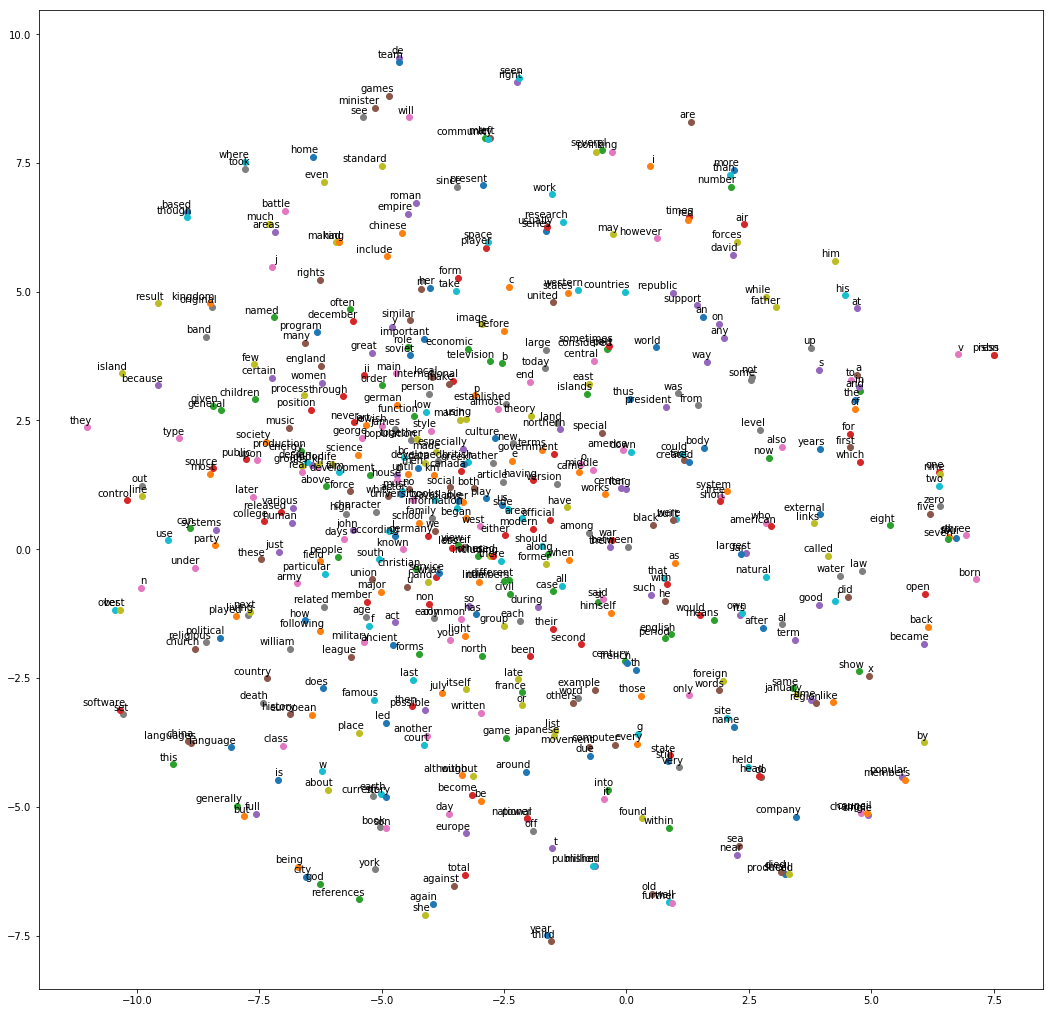

In [66]:
plot_with_labels(low_dim_embed,labels)